# Fine-tune GIT on a custom dataset for image captioning

In this notebook, we'll fine-tune [GIT](https://huggingface.co/docs/transformers/main/en/model_doc/git), short for GenerativeImage2Text, on a toy image captioning dataset.

GIT is, at the moment of writing, a state-of-the-art image/video captioning and question answering (QA) model.

## Set-up environment

First, let's install 🤗 Transformers as well as 🤗 Datasets.

In [53]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [54]:
!pip install -q datasets


In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Create image captioning dataset

Next, we'll create a tiny image captioning dataset, which as you might have guessed consists of (image, text) pairs.



In [56]:
import csv
import json

# File paths
csv_file_path = '/content/drive/MyDrive/dataset/stanford_img/content/cultural_english_caption.csv'


# List to hold the JSON data
captions = []

# Read the CSV file and convert to JSON format
with open(csv_file_path, mode='r', encoding='utf-8') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        captions.append({
            "file_name": row['Image_name']+".jpg",
            "text": row['Paragraph']
        })



In [ ]:
captions

[{'file_name': 'p_1.jpg',
  'text': 'The wooden temple with a pagoda roof and colorful prayer flags in Nepal, Kathmandu. The temple has intricate carvings and decorations on its walls and pillars. The temple is located in a busy area with other buildings and structures nearby.  people are walking around the temple, wearing black cloth and holding mobile phone.'},
 {'file_name': 'p_2.jpg',
  'text': ' It is the temple in Nepal with ornate pillars and statues. The temple is made of wood and has a red roof. The  stone pillars have golden statues resembling animals on top. The temple is located in a courtyard with a stone floor. The temple background has trees.'},
 {'file_name': 'p_3.jpg',
  'text': 'Traditional Nepali temple having white color on the wall, with a serene pond and bridge in the foreground. People gather around the pond, standing on the stairs  and ascend the steps towards the temple. The clear blue sky enhances the beauty of the scene.'},
 {'file_name': 'p_4.jpg',
  'text':

In [57]:
import json


# path to the folder containing the images

root = "/content/drive/MyDrive/dataset/stanford_img/content/cultural_images/"
# add metadata.jsonl file to this folder
with open(root + "metadata.jsonl", 'w') as f:
    for item in captions:
        print(item)
        f.write(json.dumps(item) + "\n")

{'file_name': 'p_1.jpg', 'text': 'The wooden temple with a pagoda roof and colorful prayer flags in Nepal, Kathmandu. The temple has intricate carvings and decorations on its walls and pillars. The temple is located in a busy area with other buildings and structures nearby.  people are walking around the temple, wearing black cloth and holding mobile phone.'}
{'file_name': 'p_2.jpg', 'text': ' It is the temple in Nepal with ornate pillars and statues. The temple is made of wood and has a red roof. The  stone pillars have golden statues resembling animals on top. The temple is located in a courtyard with a stone floor. The temple background has trees.'}
{'file_name': 'p_3.jpg', 'text': 'Traditional Nepali temple having white color on the wall, with a serene pond and bridge in the foreground. People gather around the pond, standing on the stairs  and ascend the steps towards the temple. The clear blue sky enhances the beauty of the scene.'}
{'file_name': 'p_4.jpg', 'text': 'It an image o

Metadata updated successfully.


Next, we use the [ImageFolder](https://huggingface.co/docs/datasets/main/en/image_dataset#imagefolder) feature to quickly turn this into a 🤗 Dataset. We'll specify that this is just the training split of the dataset.

In [58]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="/content/drive/MyDrive/dataset/stanford_img/content/cultural_images", split="train")

Resolving data files:   0%|          | 0/799 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Let's check whether the dataset is created correctly:

In [59]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 798
})

Let's take a look at one example:

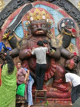

In [60]:
example = dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

Let's check its corresponding caption:

In [61]:
print(example["text"])

This is  statue of Kaal Khairav in kathmandu Durbar Square. The statue is black in color. The statue has big eyes and teeth. The statue has six hands. The crown is red and yellow in color. The devotees are worshipping in front of it.


## Create PyTorch Dataset

Next, we create a standard [PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Each item of the dataset returns the expected inputs for the model, in this case input_ids, attention_mask and pixel_values.

We use `GitProcessor` to turn each (image, text) pair into the expected inputs. Basically, the text gets turned into `input_ids` and `attention_mask`, and the image gets turned into `pixel_values`.

In [62]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

In [64]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base")

In [65]:
train_dataset = ImageCaptioningDataset(dataset, processor)

Let's check one example of the dataset:

In [66]:
item = train_dataset[0]
for k,v in item.items():
  print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


## Create PyTorch DataLoader

Next, we create a corresponding [PyTorch DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allows us to get batches of data from the dataset.

We need this as neural networks (like GIT) are trained on batches of data, using stochastic gradient descent (SGD).

In [67]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [68]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


Let's check one batch, and do some sanity checks. We can decode the input_ids back into text for instance:

In [69]:
processor.decode(batch["input_ids"][0])

'[CLS] large open space with a stone floor. in the background, there are a few buildings with white walls and red roofs. the sky is filled with birds and the sun is shining through the trees. tall, green trees are visible. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

We can "denormalize" the pixel values to get back an image:

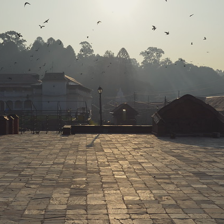

In [70]:
from PIL import Image
import numpy as np

MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

Looks ok! Always important to check your data ;) see [this blog](http://karpathy.github.io/2019/04/25/recipe/) for a great overview of tips when training neural networks.

## Define model

Next, we instantiate a model. We start from the pre-trained GIT-base model (which was already pre-trained on 4 million image-text pairs by Microsoft).

Of course, feel free to start fine-tuning another GIT model from the [hub](https://huggingface.co/models?other=git).

In [71]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

## Dummy forward pass

It's always good to check the initial loss on a batch. See also the blog above.

In [72]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(11.5972, grad_fn=<NllLossBackward0>)

## Train the model

Next, let's train the model! We use native PyTorch here.

As I created a super tiny dataset just for demo purposes, we'll let the model overfit it. If it's capable of overfitting it (i.e. achieve zero loss), then that's a great way to know that everything is working properly. See also the blog above.

In [73]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0
Loss: 11.473772048950195
Loss: 9.94808578491211
Loss: 9.696449279785156
Loss: 9.365405082702637
Loss: 8.983427047729492
Loss: 9.414619445800781
Loss: 8.710516929626465
Loss: 8.666945457458496


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (91149750 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Loss: 8.374480247497559
Loss: 8.451834678649902
Loss: 8.323471069335938
Loss: 8.137301445007324
Loss: 7.8994951248168945
Loss: 7.741697788238525
Loss: 7.751344203948975
Loss: 7.581202030181885
Loss: 7.514248371124268
Loss: 7.389591217041016
Loss: 7.312984466552734
Loss: 7.383886337280273
Loss: 7.1515889167785645
Loss: 6.956764221191406
Loss: 6.966397285461426
Loss: 6.889155387878418
Loss: 6.741340637207031
Loss: 6.650195598602295
Loss: 6.577656269073486
Loss: 6.526752948760986
Loss: 6.32558012008667
Loss: 6.32348108291626
Loss: 6.164575099945068
Loss: 6.0304718017578125
Loss: 6.042176723480225
Loss: 5.920359134674072
Loss: 5.859172344207764
Loss: 5.775588512420654
Loss: 5.523375511169434
Loss: 5.457683563232422
Loss: 5.3755059242248535
Loss: 5.3380022048950195
Loss: 5.181684970855713
Loss: 5.222114086151123
Loss: 5.012518882751465
Loss: 4.793750286102295
Loss: 4.768611907958984
Loss: 4.58329963684082
Loss: 4.461254596710205
Loss: 4.4280571937561035
Loss: 4.373254776000977
Loss: 4.36843

KeyboardInterrupt: 

## Inference

Now that we've trained the model, let's load the one of the cultural heritage image  image and perform inference on it.

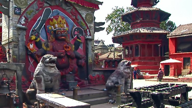

In [81]:
# load image
example = dataset[1]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [82]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=300)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

this is a photo of a temple complex in nepal. the temple is made of wood and has a red roof. the temple is surrounded by trees and greenery. the temple is made of a stone and there are people walking around the temple.
